In [1]:
import requests
import time
import os
from tqdm import tqdm

import json
import pandas as pd
#from concurrent.futures import ThreadPoolExecutor
#import pickle

c:\Users\agust\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\agust\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
os.getcwd()

'c:\\Users\\agust\\Documents\\SEDS\\SEDS_thesis\\1_nyt_ineq_articles'

#### Note: For 1980 articles from June onwards were counted since this is when the NexisUni Database Dataload starts

11. Is there an API call limit?<br>
500 requests per day <br>
5 requests per minute <br>
You should sleep 12 seconds between calls to avoid hitting the per minute rate limit <br>
If you need a higher rate limit, please contact us at code@nytimes.com.

In [4]:
#Total needed
(2024-1980)*12+6

534

API Download

In [5]:
# Your API key
with open("nyt_api_key.txt", "r") as file: 
    API_KEY = file.read() 
    
BASE_URL = "https://api.nytimes.com/svc/archive/v1"

# Create a directory to store results
# os.makedirs("nyt_archive_data", exist_ok=True)

In [6]:
# Retrieval
start_year = 2024
start_month = 12
end_year = 2024
end_month = 12

In [7]:
# Loop through years and months
for year in range(start_year, end_year + 1):
    for month in range(1, 13):
        if year == start_year and month < start_month:
            continue
        if year == end_year and month > end_month:
            break
        
        # Construct the request URL
        url = f"{BASE_URL}/{year}/{month}.json?api-key={API_KEY}"
        print(f"Fetching data for {year}-{month:02d}")
        
        try:
            # Make the request
            response = requests.get(url)
            response.raise_for_status()  # Raise an error for bad responses
            
            # Save the response to a file
            file_name = f"nyt_archive_data/nyt-{year}-{month:02d}.json"
            with open(file_name, "w") as file:
                file.write(response.text)
            
            print(f"Saved data for {year}-{month:02d} to {file_name}")
        
        except requests.exceptions.RequestException as e:
            print(f"Failed to fetch data for {year}-{month:02d}: {e}")
        
        # Respect API rate limits (e.g., 5 requests per second)
        time.sleep(12)

Fetching data for 2024-12
Saved data for 2024-12 to nyt_archive_data/nyt-2024-12.json


Check all folders availability

In [8]:
def check_all_months(folder_path, start_year, end_year):
    """
    Checks if all months (01 to 12) exist for each year in the specified folder.
    The files are assumed to be named in the format 'nyt-YYYY-MM'.
    
    Parameters:
        folder_path (str): Path to the folder containing files.
        start_year (int): Starting year to check.
        end_year (int): Ending year to check.
    
    Returns:
        dict: A dictionary with years as keys and missing months as values.
              If all months exist for a year, the value is an empty list.
    """
    # Get all files in the folder
    files_in_folder = os.listdir(folder_path)
    
    # Initialize a dictionary to track missing months
    missing_months = {}
    
    # Loop through each year
    for year in range(start_year, end_year + 1):
        # Expected file names for each month
        expected_files = [f"nyt-{year}-{str(month).zfill(2)}" for month in range(1, 13)]
        
        # Check which files are missing
        existing_files = [f.split(".")[0] for f in files_in_folder if f.startswith(f"nyt-{year}")]
        missing = [file for file in expected_files if file not in existing_files]
        
        # Record missing months
        missing_months[year] = missing
    
    return missing_months

In [9]:
# Example usage
folder_path = "nyt_archive_data"  # Replace with your folder path
start_year = 1981 #all six 1980 months are available
end_year = 2024   # only december should be missing

missing_files = check_all_months(folder_path, start_year, end_year)
for year, missing in missing_files.items():
    if missing:
        print(f"Year {year} is missing: {', '.join(missing)}")

#Year 1983 is missing: nyt-1983-02 #already retrieved

Handling problem with document with error (redownloaded, fixed)

In [10]:
with open("nyt_archive_data/nyt-2003-07.json", "r") as file:
        data = json.load(file)

In [11]:
file_path = "nyt_archive_data/nyt-2003-07.json"

with open(file_path, "r") as file:
    content = file.read()

#first was truncated document request

In [12]:
print(data['response']['docs'][3])
print(len(data['response']['docs'][3]))

{'abstract': "Letter from Diane Archer, Medicare Rights Center, says Congress's Medicare prescription plan will probably not provide relief to older Americans who struggle to pay for medications unless it sets fair prices; drawing (Jun 27 article)", 'web_url': 'https://www.nytimes.com/2003/07/01/opinion/l-medicare-plan-relief-or-placebo-338575.html', 'snippet': "Letter from Diane Archer, Medicare Rights Center, says Congress's Medicare prescription plan will probably not provide relief to older Americans who struggle to pay for medications unless it sets fair prices; drawing (Jun 27 article)", 'lead_paragraph': 'To the Editor:', 'print_section': 'A', 'print_page': '22', 'source': 'The New York Times', 'multimedia': [], 'headline': {'main': 'Medicare Plan: Relief or Placebo?', 'kicker': None, 'content_kicker': None, 'print_headline': 'Medicare Plan: Relief or Placebo?', 'name': None, 'seo': None, 'sub': None}, 'keywords': [{'name': 'glocations', 'value': 'United States', 'rank': 1, 'maj

Load requests from folder

In [13]:
def count_articles_by_month(folder_path):
    """
    Counts the number of articles for each month based on JSON files in the folder,
    with a progress bar and includes a 'year' column.

    Parameters:
        folder_path (str): Path to the folder containing JSON files.

    Returns:
        pd.DataFrame: DataFrame with columns 'month_year', 'year', and 'article_count'.
    """
    monthly_counts = []
    json_files = [file_name for file_name in os.listdir(folder_path) if file_name.endswith(".json")]

    # Use tqdm for a progress bar
    for file_name in tqdm(json_files, desc="Processing files"):
        file_path = os.path.join(folder_path, file_name)
        
        try:
            # Extract the month and year from the filename
            # Assuming file names follow the format 'nyt-YYYY-MM.json'
            month_year = file_name.split('-')[1] + '-' + file_name.split('-')[2].split('.')[0]
            year = file_name.split('-')[1]  # Extract year only
            
            # Load the JSON content and count articles
            with open(file_path, "r") as file:
                data = json.load(file)
                article_count = len(data.get("response", {}).get("docs", []))
            
            # Append results
            monthly_counts.append({'month_year': month_year, 'year': year, 'article_count': article_count})
        
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON in file: {file_name} - {e}")
        except Exception as e:
            print(f"Unexpected error with file: {file_name} - {e}")

    # Create a DataFrame from the results
    df_counts = pd.DataFrame(monthly_counts)

    return df_counts

In [14]:
# Example usage
folder_path = "nyt_archive_data"
monthly_article_counts = count_articles_by_month(folder_path)

# Print the DataFrame
monthly_article_counts.head()

Processing files:   0%|          | 0/535 [00:00<?, ?it/s]

Processing files:  29%|██▉       | 157/535 [00:38<01:33,  4.06it/s]


KeyboardInterrupt: 

In [ ]:
# monthly_article_counts.to_csv('python_objects/monthly_counts_nyt_non_ineq_article.csv', index=False)

Articles total count

In [2]:
nyt_article_counts = pd.read_csv('python_objects/monthly_counts_nyt_non_ineq_article.csv')

In [16]:
nyt_article_counts.columns

Index(['month_year', 'year', 'article_count'], dtype='object')

In [3]:
# Group by the 'year' column and sum up the 'article_count'
total_articles_per_year = nyt_article_counts.groupby('year')['article_count'].sum().reset_index()

# Rename columns for clarity
total_articles_per_year.columns = ['year', 'total_article_count']

# Display the result
total_articles_per_year.head()

,year,total_article_count
0,1980,47562
1,1981,95131
2,1982,99841
3,1983,105250
4,1984,111359


In [18]:
# total_articles_per_year.to_csv('python_objects/yearly_counts_nyt_non_ineq_articles.csv', index=False)

Load

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker


In [5]:
#Import total number of speeches per year to later create proportions
total_articles_per_year = pd.read_csv('python_objects/yearly_counts_nyt_non_ineq_articles.csv')

#For 1980 articles from June onwards were counted since this is when the NexisUni Database Dataload starts

In [21]:
total_articles_per_year.head(3)

,year,total_article_count
0,1980,47562
1,1981,95131
2,1982,99841


In [22]:
# Data preparation: Filter and ensure numeric years
#total_speeches_per_year = total_speeches_per_year[total_speeches_per_year.index >= 1980]
years = total_articles_per_year.index.astype(int)

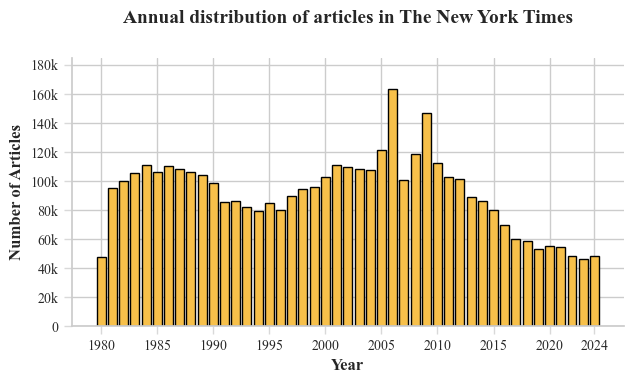

In [ ]:
# Set up the plotting theme and font
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'Times New Roman'

# Create figure with size based on LaTeX's linewidth
fig_width_inch = 6.5  # Typical figure width for LaTeX
fig_height_inch = 4   # Adjust to maintain aspect ratio
plt.figure(figsize=(fig_width_inch, fig_height_inch))

# Define color for bars
bar_color = "#F7C04A" ##EFB700

# Plot the data
plt.bar(total_articles_per_year['year'], total_articles_per_year['total_article_count'], color=bar_color, edgecolor="black", width=0.8, align="center")

# Titles and labels
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Number of Articles", fontsize=12, fontweight="bold")
plt.title("Annual distribution of articles in The New York Times", fontsize=14, fontweight="bold", pad=25)

# Set x-axis ticks every 10 years (adjust to your data range)
x_ticks = np.arange(min(total_articles_per_year['year']), max(total_articles_per_year['year']) + 1, 5).tolist()
x_ticks.append(2024)
plt.xticks(x_ticks, fontsize=12)

# Format y-axis ticks to display values in 'k' for thousands
y_ticks = np.arange(0, 181000, 20000).tolist()  # Set ticks every 20k
plt.yticks(y_ticks, fontsize=12)
plt.ylim(0, 185000)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k' if x >= 1000 else str(int(x))))

# Make tick marks stand out outside the axis
plt.gca().tick_params(which="both", bottom=True, left=True, length=6, width=1, color='#D9D9D9', labelsize=10)

# Remove unnecessary spines for cleaner appearance
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot as a high-quality PNG image
plt.savefig("annual_articles_distribution.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()
